In [1]:
import numpy as np

In [2]:
def rastrigin(*X, A = 10):
    return A*len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

In [3]:
rastrigin(0, 0)

0.0

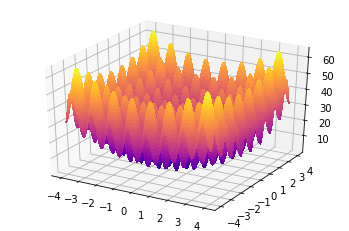

In [4]:
%matplotlib inline  

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np



X = np.linspace(-4, 4, 200)    
Y = np.linspace(-4, 4, 200)    

X, Y = np.meshgrid(X, Y)

Z = rastrigin(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    

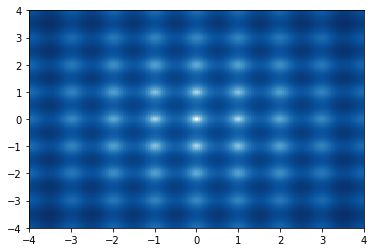

In [5]:
import matplotlib.colors as colors

plt.pcolormesh(
        X,
        Y,
        Z,
        cmap=plt.cm.get_cmap('Blues'),
        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=Z.min(), vmax=Z.max())
)

In [6]:
from auxein.fitness import Fitness

In [7]:
class GlobalMinumum(Fitness):
    
    def __init__(self, kernel):
        super().__init__()
        self.kernel = kernel
    
    def fitness(self, individual) -> float:
        dna = individual.genotype.dna
        return -1 * self.kernel(dna[0], dna[1])
    
    def value(self, individual, x):
        pass

fitness_function = GlobalMinumum(rastrigin)

In [8]:
from auxein.population import build_fixed_dimension_population
population = build_fixed_dimension_population(2, 100, fitness_function, dna_interval=(-10, -5))

In [9]:
from auxein.playgrounds import Static
from auxein.mutations import SelfAdaptiveSingleStep
from auxein.recombinations import SimpleArithmetic
from auxein.parents.distributions import SigmaScaling
from auxein.parents.selections import StochasticUniversalSampling
from auxein.replacements import ReplaceWorst

In [10]:
offspring_size = 2
playground = Static(
    population = population,
    fitness = fitness_function,
    mutation = SelfAdaptiveSingleStep(0.05),
    distribution = SigmaScaling(),
    selection = StochasticUniversalSampling(offspring_size = offspring_size),
    recombination = SimpleArithmetic(alpha = 0.5),
    replacement = ReplaceWorst(offspring_size = offspring_size)
)

In [11]:
stats = playground.train(2000)

INFO:root:Starting evolution cycle with a maximum of 2000 generations
DEBUG:root:0/2000 -- average_fitness: -136.62447572436184
DEBUG:root:1/2000 -- average_fitness: -135.26425276501857
DEBUG:root:2/2000 -- average_fitness: -133.86884989704032
DEBUG:root:3/2000 -- average_fitness: -132.9328090629028
DEBUG:root:4/2000 -- average_fitness: -131.61708346890006
DEBUG:root:5/2000 -- average_fitness: -130.21245668898618
DEBUG:root:6/2000 -- average_fitness: -128.2566502926421
DEBUG:root:7/2000 -- average_fitness: -127.78545453466
DEBUG:root:8/2000 -- average_fitness: -127.10463316210102
DEBUG:root:9/2000 -- average_fitness: -125.4548491067603
DEBUG:root:10/2000 -- average_fitness: -124.56775518161812
DEBUG:root:11/2000 -- average_fitness: -123.33482675598165
DEBUG:root:12/2000 -- average_fitness: -122.00147430058105
DEBUG:root:13/2000 -- average_fitness: -121.19193932333404
DEBUG:root:14/2000 -- average_fitness: -120.31330411134284
DEBUG:root:15/2000 -- average_fitness: -118.67354506305301
DE

DEBUG:root:140/2000 -- average_fitness: -61.59833824895045
DEBUG:root:141/2000 -- average_fitness: -61.464813241123785
DEBUG:root:142/2000 -- average_fitness: -61.084082714141076
DEBUG:root:143/2000 -- average_fitness: -60.824803097109914
DEBUG:root:144/2000 -- average_fitness: -60.44741935440375
DEBUG:root:145/2000 -- average_fitness: -60.174161106067615
DEBUG:root:146/2000 -- average_fitness: -60.06070009105922
DEBUG:root:147/2000 -- average_fitness: -59.92569228860734
DEBUG:root:148/2000 -- average_fitness: -59.54265908732749
DEBUG:root:149/2000 -- average_fitness: -59.193428846674095
DEBUG:root:150/2000 -- average_fitness: -59.174809371740274
DEBUG:root:151/2000 -- average_fitness: -58.69111089877173
DEBUG:root:152/2000 -- average_fitness: -58.47991872787339
DEBUG:root:153/2000 -- average_fitness: -58.36267646980141
DEBUG:root:154/2000 -- average_fitness: -57.994138655853675
DEBUG:root:155/2000 -- average_fitness: -57.634162686573156
DEBUG:root:156/2000 -- average_fitness: -57.2541

DEBUG:root:279/2000 -- average_fitness: -36.168391972230026
DEBUG:root:280/2000 -- average_fitness: -36.01717023427392
DEBUG:root:281/2000 -- average_fitness: -35.909460916542415
DEBUG:root:282/2000 -- average_fitness: -35.44737603317577
DEBUG:root:283/2000 -- average_fitness: -35.323190003809216
DEBUG:root:284/2000 -- average_fitness: -34.91104730248181
DEBUG:root:285/2000 -- average_fitness: -34.8340668332436
DEBUG:root:286/2000 -- average_fitness: -34.73788383401566
DEBUG:root:287/2000 -- average_fitness: -34.94104407952253
DEBUG:root:288/2000 -- average_fitness: -34.53998182398362
DEBUG:root:289/2000 -- average_fitness: -34.44955230601717
DEBUG:root:290/2000 -- average_fitness: -34.49978906502268
DEBUG:root:291/2000 -- average_fitness: -34.30938155478559
DEBUG:root:292/2000 -- average_fitness: -34.28739379545826
DEBUG:root:293/2000 -- average_fitness: -33.914063037692806
DEBUG:root:294/2000 -- average_fitness: -33.68943892570012
DEBUG:root:295/2000 -- average_fitness: -33.912800429

DEBUG:root:417/2000 -- average_fitness: -18.752510167383164
DEBUG:root:418/2000 -- average_fitness: -18.607024468368316
DEBUG:root:419/2000 -- average_fitness: -18.43494597210753
DEBUG:root:420/2000 -- average_fitness: -18.433304735792444
DEBUG:root:421/2000 -- average_fitness: -18.623523857772124
DEBUG:root:422/2000 -- average_fitness: -18.794106691111562
DEBUG:root:423/2000 -- average_fitness: -18.41998072195339
DEBUG:root:424/2000 -- average_fitness: -18.219608089302238
DEBUG:root:425/2000 -- average_fitness: -18.29322045565524
DEBUG:root:426/2000 -- average_fitness: -18.200089412819008
DEBUG:root:427/2000 -- average_fitness: -18.340103587616092
DEBUG:root:428/2000 -- average_fitness: -18.17423721988787
DEBUG:root:429/2000 -- average_fitness: -18.117700770335393
DEBUG:root:430/2000 -- average_fitness: -17.970203629125823
DEBUG:root:431/2000 -- average_fitness: -18.183328414962695
DEBUG:root:432/2000 -- average_fitness: -17.844509096171954
DEBUG:root:433/2000 -- average_fitness: -17.

DEBUG:root:555/2000 -- average_fitness: -12.96341984499154
DEBUG:root:556/2000 -- average_fitness: -12.989319221081288
DEBUG:root:557/2000 -- average_fitness: -12.807285707756723
DEBUG:root:558/2000 -- average_fitness: -12.742686436619687
DEBUG:root:559/2000 -- average_fitness: -12.44231780923702
DEBUG:root:560/2000 -- average_fitness: -12.648880973437006
DEBUG:root:561/2000 -- average_fitness: -12.566274821825294
DEBUG:root:562/2000 -- average_fitness: -12.73081299361829
DEBUG:root:563/2000 -- average_fitness: -12.61913314796289
DEBUG:root:564/2000 -- average_fitness: -12.668199529170042
DEBUG:root:565/2000 -- average_fitness: -12.49356215656103
DEBUG:root:566/2000 -- average_fitness: -12.706425760192703
DEBUG:root:567/2000 -- average_fitness: -12.633452350613775
DEBUG:root:568/2000 -- average_fitness: -12.802397147602099
DEBUG:root:569/2000 -- average_fitness: -12.574452174252292
DEBUG:root:570/2000 -- average_fitness: -12.687378794539852
DEBUG:root:571/2000 -- average_fitness: -12.5

DEBUG:root:693/2000 -- average_fitness: -9.5932189374373
DEBUG:root:694/2000 -- average_fitness: -9.57291980050438
DEBUG:root:695/2000 -- average_fitness: -9.56981664612806
DEBUG:root:696/2000 -- average_fitness: -9.696014054129321
DEBUG:root:697/2000 -- average_fitness: -9.375189217185943
DEBUG:root:698/2000 -- average_fitness: -9.461664744305677
DEBUG:root:699/2000 -- average_fitness: -9.490219353744445
DEBUG:root:700/2000 -- average_fitness: -9.39205353243994
DEBUG:root:701/2000 -- average_fitness: -9.561520357024527
DEBUG:root:702/2000 -- average_fitness: -9.472898627913892
DEBUG:root:703/2000 -- average_fitness: -9.45585382983532
DEBUG:root:704/2000 -- average_fitness: -9.4886854884892
DEBUG:root:705/2000 -- average_fitness: -9.358520280621784
DEBUG:root:706/2000 -- average_fitness: -9.718234175867003
DEBUG:root:707/2000 -- average_fitness: -9.526402104320285
DEBUG:root:708/2000 -- average_fitness: -9.318184781068906
DEBUG:root:709/2000 -- average_fitness: -9.155439322763618
DEBUG

DEBUG:root:833/2000 -- average_fitness: -7.885496613194506
DEBUG:root:834/2000 -- average_fitness: -7.964280853183284
DEBUG:root:835/2000 -- average_fitness: -7.863278242738743
DEBUG:root:836/2000 -- average_fitness: -7.935036466344022
DEBUG:root:837/2000 -- average_fitness: -7.99064807527074
DEBUG:root:838/2000 -- average_fitness: -8.105896250090508
DEBUG:root:839/2000 -- average_fitness: -7.954230045306684
DEBUG:root:840/2000 -- average_fitness: -7.788123154501712
DEBUG:root:841/2000 -- average_fitness: -8.038221420569503
DEBUG:root:842/2000 -- average_fitness: -8.12745056582735
DEBUG:root:843/2000 -- average_fitness: -8.059993542766456
DEBUG:root:844/2000 -- average_fitness: -7.860732950606689
DEBUG:root:845/2000 -- average_fitness: -8.116052224285156
DEBUG:root:846/2000 -- average_fitness: -7.864996829805705
DEBUG:root:847/2000 -- average_fitness: -8.148951781427142
DEBUG:root:848/2000 -- average_fitness: -8.08973528901642
DEBUG:root:849/2000 -- average_fitness: -8.139058163983856


DEBUG:root:972/2000 -- average_fitness: -6.935622542311401
DEBUG:root:973/2000 -- average_fitness: -6.914401181647934
DEBUG:root:974/2000 -- average_fitness: -6.631300735194503
DEBUG:root:975/2000 -- average_fitness: -6.591010359195548
DEBUG:root:976/2000 -- average_fitness: -6.70858188657975
DEBUG:root:977/2000 -- average_fitness: -6.9756720537271555
DEBUG:root:978/2000 -- average_fitness: -7.0481636405598875
DEBUG:root:979/2000 -- average_fitness: -6.574277786065452
DEBUG:root:980/2000 -- average_fitness: -6.692891017563245
DEBUG:root:981/2000 -- average_fitness: -6.775266495395908
DEBUG:root:982/2000 -- average_fitness: -6.830513297357088
DEBUG:root:983/2000 -- average_fitness: -7.102396125390426
DEBUG:root:984/2000 -- average_fitness: -6.904318519348236
DEBUG:root:985/2000 -- average_fitness: -7.624658864018267
DEBUG:root:986/2000 -- average_fitness: -7.074842115170217
DEBUG:root:987/2000 -- average_fitness: -6.630267950542555
DEBUG:root:988/2000 -- average_fitness: -6.441957363380

DEBUG:root:1109/2000 -- average_fitness: -5.914520601149281
DEBUG:root:1110/2000 -- average_fitness: -6.4073868121937885
DEBUG:root:1111/2000 -- average_fitness: -6.71806215793003
DEBUG:root:1112/2000 -- average_fitness: -5.978401203314199
DEBUG:root:1113/2000 -- average_fitness: -6.111955037773919
DEBUG:root:1114/2000 -- average_fitness: -6.0804412760121895
DEBUG:root:1115/2000 -- average_fitness: -5.995920032156869
DEBUG:root:1116/2000 -- average_fitness: -6.461053707027562
DEBUG:root:1117/2000 -- average_fitness: -6.20616611090091
DEBUG:root:1118/2000 -- average_fitness: -6.3267568453851535
DEBUG:root:1119/2000 -- average_fitness: -5.750819475562257
DEBUG:root:1120/2000 -- average_fitness: -6.192340083145427
DEBUG:root:1121/2000 -- average_fitness: -5.952688435858324
DEBUG:root:1122/2000 -- average_fitness: -6.172274143539674
DEBUG:root:1123/2000 -- average_fitness: -5.942486931189155
DEBUG:root:1124/2000 -- average_fitness: -6.01330417657737
DEBUG:root:1125/2000 -- average_fitness:

DEBUG:root:1246/2000 -- average_fitness: -5.791229904090669
DEBUG:root:1247/2000 -- average_fitness: -5.430363921311972
DEBUG:root:1248/2000 -- average_fitness: -5.25040314612025
DEBUG:root:1249/2000 -- average_fitness: -5.349702028299025
DEBUG:root:1250/2000 -- average_fitness: -5.391786083869365
DEBUG:root:1251/2000 -- average_fitness: -5.389351750317847
DEBUG:root:1252/2000 -- average_fitness: -5.186507531747708
DEBUG:root:1253/2000 -- average_fitness: -5.342518391431978
DEBUG:root:1254/2000 -- average_fitness: -5.368375483984831
DEBUG:root:1255/2000 -- average_fitness: -5.272520346023627
DEBUG:root:1256/2000 -- average_fitness: -5.456720318217541
DEBUG:root:1257/2000 -- average_fitness: -5.300773169942317
DEBUG:root:1258/2000 -- average_fitness: -5.530678398144797
DEBUG:root:1259/2000 -- average_fitness: -5.523612967837089
DEBUG:root:1260/2000 -- average_fitness: -5.577474700023306
DEBUG:root:1261/2000 -- average_fitness: -5.787042013303225
DEBUG:root:1262/2000 -- average_fitness: 

DEBUG:root:1383/2000 -- average_fitness: -5.514851909780626
DEBUG:root:1384/2000 -- average_fitness: -5.169468038301749
DEBUG:root:1385/2000 -- average_fitness: -5.45214389887405
DEBUG:root:1386/2000 -- average_fitness: -5.337626034435239
DEBUG:root:1387/2000 -- average_fitness: -5.517148548314557
DEBUG:root:1388/2000 -- average_fitness: -5.497371450558874
DEBUG:root:1389/2000 -- average_fitness: -4.997817576670688
DEBUG:root:1390/2000 -- average_fitness: -5.540933457549517
DEBUG:root:1391/2000 -- average_fitness: -5.386902218101702
DEBUG:root:1392/2000 -- average_fitness: -5.241950064504392
DEBUG:root:1393/2000 -- average_fitness: -5.439800641096368
DEBUG:root:1394/2000 -- average_fitness: -5.1286915538860045
DEBUG:root:1395/2000 -- average_fitness: -5.116416150341549
DEBUG:root:1396/2000 -- average_fitness: -5.04000012355784
DEBUG:root:1397/2000 -- average_fitness: -5.025334795296566
DEBUG:root:1398/2000 -- average_fitness: -4.877903114642734
DEBUG:root:1399/2000 -- average_fitness: 

DEBUG:root:1520/2000 -- average_fitness: -4.280769323289008
DEBUG:root:1521/2000 -- average_fitness: -4.302908955602104
DEBUG:root:1522/2000 -- average_fitness: -4.369202040686456
DEBUG:root:1523/2000 -- average_fitness: -4.222705354641313
DEBUG:root:1524/2000 -- average_fitness: -4.4627190577701725
DEBUG:root:1525/2000 -- average_fitness: -4.681391610035361
DEBUG:root:1526/2000 -- average_fitness: -4.482697421982654
DEBUG:root:1527/2000 -- average_fitness: -4.459870039165069
DEBUG:root:1528/2000 -- average_fitness: -4.41374889142646
DEBUG:root:1529/2000 -- average_fitness: -4.267986153972308
DEBUG:root:1530/2000 -- average_fitness: -4.307482297583948
DEBUG:root:1531/2000 -- average_fitness: -4.666172624759272
DEBUG:root:1532/2000 -- average_fitness: -4.224578866517968
DEBUG:root:1533/2000 -- average_fitness: -4.467927724422061
DEBUG:root:1534/2000 -- average_fitness: -4.4230104012080185
DEBUG:root:1535/2000 -- average_fitness: -4.70148373020324
DEBUG:root:1536/2000 -- average_fitness:

DEBUG:root:1657/2000 -- average_fitness: -4.473159788394482
DEBUG:root:1658/2000 -- average_fitness: -4.2583454497960584
DEBUG:root:1659/2000 -- average_fitness: -3.899877347259278
DEBUG:root:1660/2000 -- average_fitness: -3.9553074989725308
DEBUG:root:1661/2000 -- average_fitness: -4.27666493645547
DEBUG:root:1662/2000 -- average_fitness: -4.162725653392357
DEBUG:root:1663/2000 -- average_fitness: -3.914359729191223
DEBUG:root:1664/2000 -- average_fitness: -4.4513906061158846
DEBUG:root:1665/2000 -- average_fitness: -4.074700155863
DEBUG:root:1666/2000 -- average_fitness: -4.223918642266251
DEBUG:root:1667/2000 -- average_fitness: -4.187511117006834
DEBUG:root:1668/2000 -- average_fitness: -3.937120040969388
DEBUG:root:1669/2000 -- average_fitness: -4.222744809600129
DEBUG:root:1670/2000 -- average_fitness: -4.163039844841545
DEBUG:root:1671/2000 -- average_fitness: -4.012387896326046
DEBUG:root:1672/2000 -- average_fitness: -4.379122296499027
DEBUG:root:1673/2000 -- average_fitness: 

DEBUG:root:1793/2000 -- average_fitness: -3.5902841022502194
DEBUG:root:1794/2000 -- average_fitness: -3.7299356698318205
DEBUG:root:1795/2000 -- average_fitness: -3.9419495183751696
DEBUG:root:1796/2000 -- average_fitness: -3.6215031753404383
DEBUG:root:1797/2000 -- average_fitness: -3.684868740877695
DEBUG:root:1798/2000 -- average_fitness: -3.468891425928444
DEBUG:root:1799/2000 -- average_fitness: -3.4876656362993286
DEBUG:root:1800/2000 -- average_fitness: -3.6632023495539054
DEBUG:root:1801/2000 -- average_fitness: -3.332816574530927
DEBUG:root:1802/2000 -- average_fitness: -3.6299664944894987
DEBUG:root:1803/2000 -- average_fitness: -3.672641219570011
DEBUG:root:1804/2000 -- average_fitness: -3.643825982117325
DEBUG:root:1805/2000 -- average_fitness: -3.7691903542348295
DEBUG:root:1806/2000 -- average_fitness: -3.5757084406397803
DEBUG:root:1807/2000 -- average_fitness: -3.666792731461895
DEBUG:root:1808/2000 -- average_fitness: -3.484127305434124
DEBUG:root:1809/2000 -- average

DEBUG:root:1929/2000 -- average_fitness: -3.2102683305086828
DEBUG:root:1930/2000 -- average_fitness: -3.5833422282843492
DEBUG:root:1931/2000 -- average_fitness: -3.493640596019101
DEBUG:root:1932/2000 -- average_fitness: -3.494404052355886
DEBUG:root:1933/2000 -- average_fitness: -3.576077459355812
DEBUG:root:1934/2000 -- average_fitness: -3.3174098862498824
DEBUG:root:1935/2000 -- average_fitness: -3.672789343642111
DEBUG:root:1936/2000 -- average_fitness: -3.4712064980724473
DEBUG:root:1937/2000 -- average_fitness: -3.723492508435868
DEBUG:root:1938/2000 -- average_fitness: -3.349911962139379
DEBUG:root:1939/2000 -- average_fitness: -3.510717270928207
DEBUG:root:1940/2000 -- average_fitness: -3.6219344652184775
DEBUG:root:1941/2000 -- average_fitness: -3.1848078110502
DEBUG:root:1942/2000 -- average_fitness: -3.451507063085783
DEBUG:root:1943/2000 -- average_fitness: -3.450486643591736
DEBUG:root:1944/2000 -- average_fitness: -3.6492295815671163
DEBUG:root:1945/2000 -- average_fitn

In [16]:
[a, b] = playground.get_most_performant().genotype.dna

In [17]:
a

-0.000957249070385302

In [18]:
b

-0.009317588080842043

In [19]:
rastrigin(a, b)

0.017400791857163256